### Loading Packages

In [134]:
import os
import sys
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import string

import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics.pairwise import cosine_similarity
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec

### Importing the saved dataframe

In [103]:
df_recipes = pd.read_pickle('./basic_features.pkl')
df_recipes.head()

,name,ingredients,ingredient_ids
0,aromatic basmati rice rice cooker,"[basmati rice, water, salt, cinnamon stick, gr...","[389, 7655, 6270, 1527, 3406]"
1,pumpkin pie a la easy,"[flour, oats, brown sugar, pecans, butter, egg...","[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,cheesy tomato soup with potatoes,"[chicken broth, water, salt, black pepper, oni...","[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,mini tacos,"[wonton wrappers, hamburger, taco seasoning, s...","[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,rosemary s hanky panky s,"[ground beef, ground sausage, velveeta cheese,...","[3484, 6324, 7594, 243]"


In [104]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178265 entries, 0 to 178264
Data columns (total 3 columns):
name              178265 non-null object
ingredients       178265 non-null object
ingredient_ids    178265 non-null object
dtypes: object(3)
memory usage: 5.4+ MB


In [105]:
df_recipes.loc[0, 'ingredients']

['basmati rice', 'water', 'salt', 'cinnamon stick', 'green cardamom pods']

In [106]:
df_recipes.loc[0, 'ingredient_ids']

[389, 7655, 6270, 1527, 3406]

### Using the selected recipes

In [107]:
selected = pd.read_csv("./selected_recipes.csv", names=['recipes_ids', 'name', 'ingredients', 'ingredient_ids'], skiprows=1)

In [108]:
selected.head()

,recipes_ids,name,ingredients,ingredient_ids
0,837,arancini italian rice balls,"['eggs', 'cooked rice', 'butter', 'parmesan ch...","[2499, 1746, 840, 5180, 3184, 2856, 6374, 3486..."
1,4562,easy fattoush salad,"['cucumber', 'garlic cloves', 'of fresh mint',...","[2001, 3203, 4985, 2856, 4403, 2320, 6276, 608..."
2,8669,alan s tandoori chicken,"['chicken breasts', 'tandoori paste', 'yogurt'...","[1252, 7079, 7998, 4403, 3184]"
3,22085,mexican tacos al pastor,"['pasilla chiles', 'guajillo chilies', 'garlic...","[1316, 3562, 3207, 7799, 2007, 7821, 6270, 286..."
4,30560,croquetas,"['eggs', 'flour', 'paprika', 'olive oil', 'sal...","[2499, 2683, 5168, 5006, 6276, 4717, 3597, 501..."


In [114]:
df_selected = df_recipes.iloc[selected.recipes_ids].reset_index(drop=True)

### Creating the vectors for calculating similarities

#### Finding similar recipes

In [115]:
ingredients = {}
for idx in df_selected.index:
    temp = dict(zip(df_selected.loc[idx, "ingredient_ids"],df_selected.loc[idx, "ingredients"]))
    ingredients.update(temp)

In [116]:
ingredients_matrix = np.zeros((len(df_selected),max(ingredients)+1), dtype=np.int8, order='C')

In [117]:
ingredients_matrix.shape

(44, 8022)

In [118]:
for idx in df_selected.index:
    for ing in df_selected.loc[idx,"ingredient_ids"]:
        ingredients_matrix[idx,ing] = 1

In [119]:
len(ingredients_matrix[ingredients_matrix>0])

422

In [121]:
df_ingredients = pd.DataFrame(data=ingredients_matrix,
                              index=df_selected.name,
                              #columns=ingredients.keys()
                              )
df_ingredients.reset_index(inplace=True)
df_ingredients.head()

,name,0,1,2,3,4,5,6,7,8,...,8012,8013,8014,8015,8016,8017,8018,8019,8020,8021
0,arancini italian rice balls,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,easy fattoush salad,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,alan s tandoori chicken,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,mexican tacos al pastor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,croquetas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Testing the similarity function
(with selected recipes)

In [125]:
ar_ingredients = df_ingredients.values

In [144]:
df_ingredients.shape

(44, 8023)

In [145]:
%%time
print(cosine_similarity(ar_ingredients[0,1:].reshape(1, -1), ar_ingredients[1,1:].reshape(1, -1)))

[[0.08333333]]
CPU times: user 1.66 ms, sys: 1.97 ms, total: 3.63 ms
Wall time: 3.44 ms


In [129]:
%%time
msim_ingredients = cosine_similarity(ar_ingredients[:,1:], ar_ingredients[:,1:])

CPU times: user 46.2 ms, sys: 18.4 ms, total: 64.7 ms
Wall time: 28.7 ms


In [130]:
msim_ingredients.shape

(44, 44)

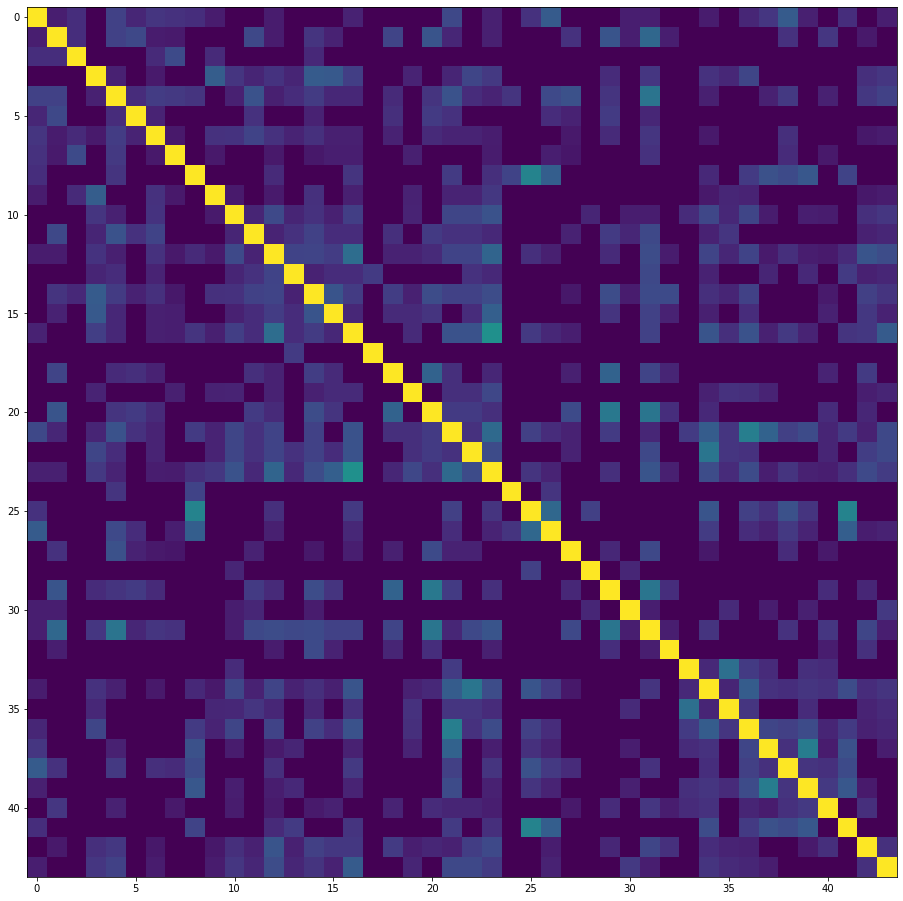

In [156]:
plt.figure(figsize=(16, 16)) 
plt.imshow(msim_ingredients, interpolation='none')
plt.show()

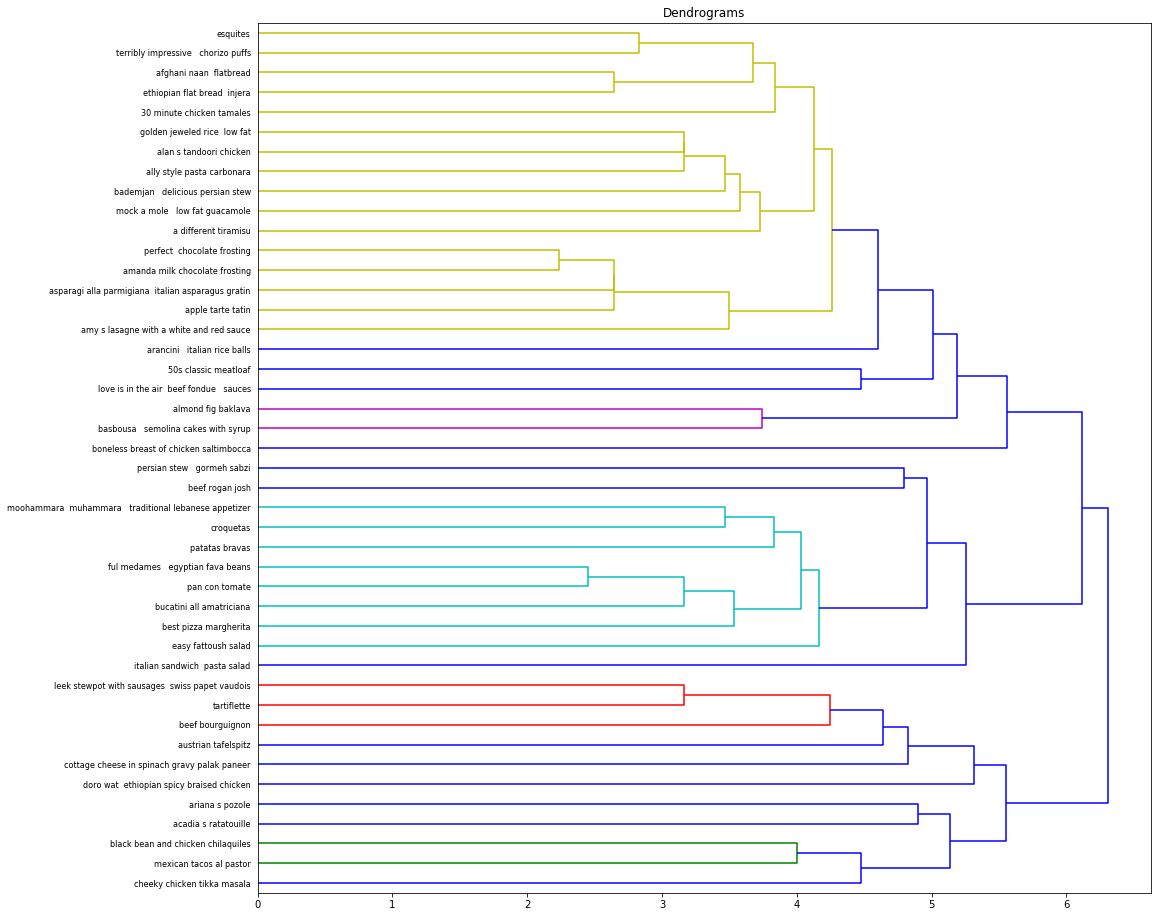

In [154]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(16, 16))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(ar_ingredients[:,1:], method='ward'), 
                      orientation='right', 
                      labels=df_ingredients.name.values)

#### Finding similar names for recipes
#### (input for the search function)

In [19]:
class Text_Cleaning_Utilities(object):
    """Tools for processing text into segments for further learning"""

    @staticmethod
    def text_to_wordlist(text, 
                         remove_stopwords=False, 
                         remove_non_letters=False, 
                         steeming=False):
        '''Split a text into a list of words'''
        #text = text.replace('-\n','')
        text = text.lower()
        if remove_non_letters:
            text = re.sub("[^-A-Za-z0-9_]", " ", text)
        list_words = word_tokenize(text)
        list_words = [w.strip(string.punctuation) for w in list_words if w not in string.punctuation]
        list_words = [w for w in list_words if len(w) > 1]
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            list_words = [w for w in list_words if w not in stops]
        if steeming:
            stemmer = PorterStemmer()
            list_words = [stemmer.stem(item) for item in list_words]
        return list_words
    
    @staticmethod
    def df_to_list_of_texts(dataframe, column, 
                            remove_stopwords=False, 
                            remove_non_letters=False, 
                            steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(' '.join(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                                 remove_stopwords=remove_stopwords,
                                                                                 remove_non_letters=remove_non_letters,
                                                                                 steeming=steeming)))
            
        return clean_texts

    @staticmethod
    def df_to_list_of_tokens(dataframe, column, 
                             remove_stopwords=False, 
                             remove_non_letters=False, 
                             steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                        remove_stopwords=remove_stopwords,
                                                                        remove_non_letters=remove_non_letters,
                                                                        steeming=steeming))
            
        return clean_texts

In [20]:
recipes = Text_Cleaning_Utilities.df_to_list_of_texts(df_recipes,
                                                      'name',
                                                      remove_stopwords=True,)

In [21]:
recipes[0:10]

['aromatic basmati rice rice cooker',
 'pumpkin pie la easy',
 'cheesy tomato soup potatoes',
 'mini tacos',
 'rosemary hanky panky',
 'pink bavarian crown strawberry dream supreme',
 'tom kelly chicken fried steak',
 'chocolate oat cookie bars',
 'tropical lemon cream bars',
 'jeera cubes barbecue marinade']

In [22]:
vectorizer_tf = CountVectorizer(input='content', 
                               encoding='utf-8', 
                               decode_error='strict', 
                               strip_accents=None, 
                               lowercase=True, 
                               preprocessor=None, 
                               tokenizer=None, 
                               stop_words=None, 
                               #token_pattern='(?u)\b\w\w+\b',
                               ngram_range=(1,1),
                               analyzer='word', 
                               max_df=1.0, 
                               min_df=5, 
                               max_features=5000, 
                               vocabulary=None, 
                               binary=False, 
                               dtype=np.int64,
                              )

vectorizer_tfidf = TfidfVectorizer(input='content',
                                  #encoding='utf-8',
                                  decode_error='strict',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=None,
                                  #token_pattern='(?u)\b\w\w+\b',
                                  ngram_range=(1, 1),
                                  max_df=1.0,
                                  min_df=1,
                                  max_features=5000,
                                  vocabulary=None, 
                                  binary=False, 
                                  dtype=np.int64,
                                  norm='l2',
                                  use_idf=True,
                                  smooth_idf=True,
                                  sublinear_tf=True)

In [23]:
recipes_vectors = vectorizer_tf.fit_transform(recipes)
recipes_vectors = recipes_vectors.toarray() # Numpy arrays are easy to work with
print(recipes_vectors.shape)

(178265, 5000)


In [30]:
find_similar(recipes_vectors[0,:], recipes_vectors[0:2000,0:], 4)

[0, 0, 0, 0.9999999999999999]


[0, 0, 0, 0.9999999999999999]